<a href="https://colab.research.google.com/github/swanny0000/ZTM-TensorFlow/blob/master/05_Tranfer_Learning_pt_2_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Surely someone has worked on a model that's similar to our problem already...
# Fine Tuning
Transfer learning can:
* leverage an existing architecture that's **proven to work** on problems similar to our own
* leverage an architecture that's already learned patterns on similar data to our own (with better result from less training data)

Feature extraction is a custom final layer capped at the end of an unmodified model that helps classify what we're looking for.

Fine tuning *doesn't freeze* the model's parameters during training.

**NOTE** Fine tuning often requires more data that feature extraction.

In [1]:
# let's get some helper functions we've stored from other notebooks... namely
# https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-11-28 04:16:15--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-11-28 04:16:15 (91.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [3]:
# let's get some data and use some built-in applications (canned architectures with pre-trained weights)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2023-11-28 04:21:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.128.207, 173.194.69.207, 173.194.79.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.128.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  40.5MB/s    in 4.7s    

2023-11-28 04:21:32 (34.1 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

In [6]:
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [7]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical")
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[8.53571472e+01 9.23571472e+01 1.23571434e+01]
   [8.93826523e+01 9.54540863e+01 2.11683693e+01]
   [9.14285736e+01 9.35714264e+01 4.09285698e+01]
   ...
   [8.83519211e+01 9.13519211e+01 2.03519173e+01]
   [8.81429062e+01 8.91429062e+01 1.91429100e+01]
   [8.93723297e+01 9.03723297e+01 2.03723316e+01]]

  [[8.71632614e+01 9.60918350e+01 1.72346935e+01]
   [8.69285736e+01 9.49285736e+01 2.16428585e+01]
   [8.99540787e+01 9.25255051e+01 4.18826523e+01]
   ...
   [9.01580734e+01 9.31580734e+01 2.21580734e+01]
   [8.94235229e+01 9.24235229e+01 2.14235210e+01]
   [9.09743805e+01 9.39743805e+01 2.29743824e+01]]

  [[8.92295914e+01 9.95867386e+01 2.33724499e+01]
   [8.95153046e+01 9.91428528e+01 2.73724499e+01]
   [9.27602005e+01 9.61173477e+01 4.70459137e+01]
   ...
   [8.36886826e+01 8.66886826e+01 1.56886854e+01]
   [8.09439087e+01 8.39439087e+01 1.29439087e+01]
   [8.16376419e+01 8.46376419e+01 1.36376448e+01]]

  ...

  [[1.48862244e+02 1.51862244e+02 1.30862244e+02]
   [1

In [28]:
# let's try building a model from efficientnetB7...
enetB7_model = tf.keras.applications.efficientnet.EfficientNetB7(input_shape=(224, 224, 3),
                                                                 weights="imagenet",
                                                                 include_top=False)
layer = enetB7_model.output
layer = tf.keras.layers.GlobalAveragePooling2D()(layer)
layer = tf.keras.layers.Dense(100, activation="relu")(layer)
layer = tf.keras.layers.Dense(10, activation="softmax")(layer)

enetB7_10_classes_model = tf.keras.models.Model(inputs=enetB7_model.input,
                                                outputs=layer)

In [29]:
for layer in enetB7_model.layers:
  layer.trainable = False

In [30]:
enetB7_10_classes_model.compile(loss="categorical_crossentropy",
                     optimizer="Adam",
                     metrics=["accuracy"])

enetB7_history = enetB7_10_classes_model.fit(train_data_10_percent,
                                             epochs=5,
                                             steps_per_epoch=len(train_data_10_percent),
                                             batch_size=32,
                                             validation_data=test_data,
                                             validation_steps=len(test_data))

Epoch 1/5
24/24 [==============================] - 85s 2s/step - loss: 1.3039 - accuracy: 0.6053 - val_loss: 0.5568 - val_accuracy: 0.8376
Epoch 2/5
24/24 [==============================] - 38s 2s/step - loss: 0.4614 - accuracy: 0.8627 - val_loss: 0.4629 - val_accuracy: 0.8556
Epoch 3/5
24/24 [==============================] - 39s 2s/step - loss: 0.3057 - accuracy: 0.9173 - val_loss: 0.4591 - val_accuracy: 0.8476
Epoch 4/5
24/24 [==============================] - 39s 2s/step - loss: 0.2264 - accuracy: 0.9360 - val_loss: 0.4563 - val_accuracy: 0.8448
Epoch 5/5
24/24 [==============================] - 50s 2s/step - loss: 0.1493 - accuracy: 0.9693 - val_loss: 0.4127 - val_accuracy: 0.8664


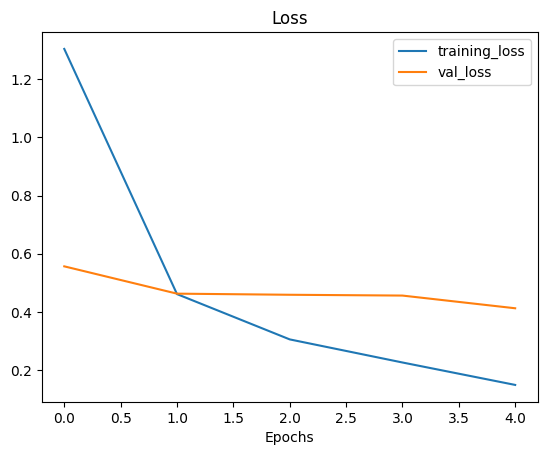

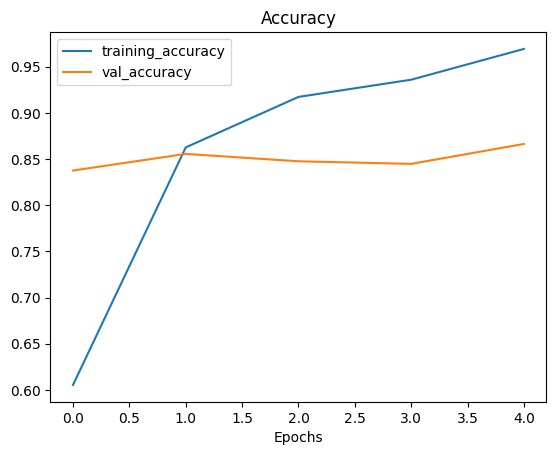

In [31]:
plot_loss_curves(enetB7_history)

## Model 0: 10% of data, no modification of training data

In [34]:
# neat! we got to overfitting pretty quick... let's regroup with the video

# 1. create base model from pre-trained model
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)

# 2. freeze the pre-trained patterns/weights!
base_model.trainable = False

# 3. create inputs for our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. (optionally) if using models like resnetV2, need to normalize inputs
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5. Pass the inputs to the base model
x = base_model(inputs)
print("Shape after #5: ", x.shape)

# 6. Average pool the outputs (collect the most important information and reduce # of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_avg_pool")(x)
print("Shape after #6: ", x.shape)

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine inputs and outputs!
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

# 10. Fit the model and save it's history
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=len(test_data), # we could speed this up by selecting less data (e.g. 25%)
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="model_0")])

Shape after #5:  (None, 7, 7, 1280)
Shape after #6:  (None, 1280)
Saving TensorBoard log files to: transfer_learning/model_0/20231128-054021
Epoch 1/5
24/24 [==============================] - 25s 408ms/step - loss: 1.9329 - accuracy: 0.3827 - val_loss: 1.3598 - val_accuracy: 0.7084
Epoch 2/5
24/24 [==============================] - 7s 277ms/step - loss: 1.1766 - accuracy: 0.7480 - val_loss: 0.9302 - val_accuracy: 0.8012
Epoch 3/5
24/24 [==============================] - 8s 344ms/step - loss: 0.8519 - accuracy: 0.8053 - val_loss: 0.7392 - val_accuracy: 0.8236
Epoch 4/5
24/24 [==============================] - 7s 286ms/step - loss: 0.6974 - accuracy: 0.8373 - val_loss: 0.6445 - val_accuracy: 0.8368
Epoch 5/5
24/24 [==============================] - 9s 350ms/step - loss: 0.5921 - accuracy: 0.8640 - val_loss: 0.5868 - val_accuracy: 0.8488


In [35]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_10
1 rescaling_16
2 normalization_9
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47

right up top... there's a rescaling layer!

In [37]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_16 (Rescaling)    (None, None, None, 3)        0         ['input_10[0][0]']            
                                                                                                  
 normalization_9 (Normaliza  (None, None, None, 3)        0         ['rescaling_16[0][0]']        
 tion)                                                                                            
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [36]:
model_0.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_avg_pool (GlobalAve  (None, 1280)              0         
 ragePooling2D)                                                  
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


this is a lot easier to look at! and notice that we only have a small number of trainable parameters... *feature extraction*

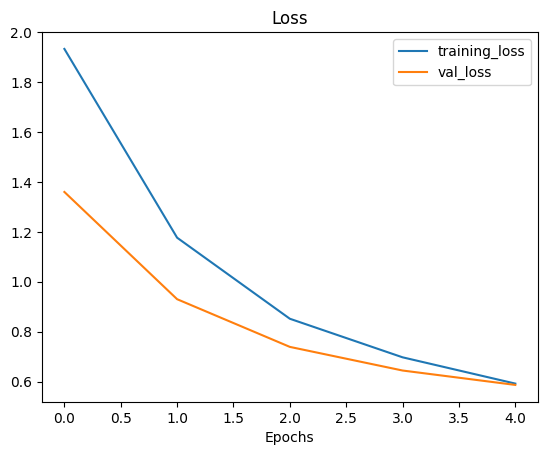

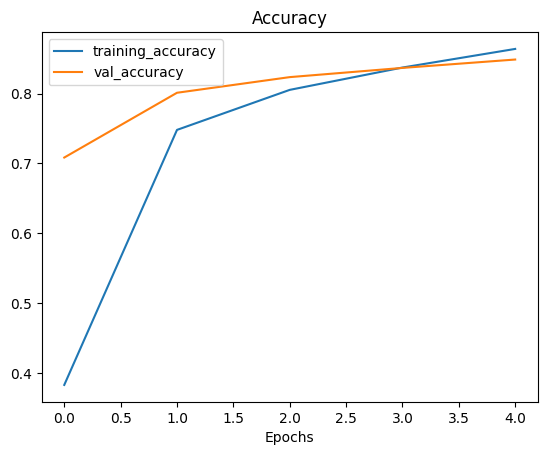

In [38]:
plot_loss_curves(history_0)

looks like we could keep training! but let's look at other options...

how would we get a feature vector from a trained model? For example, the `GlobalAveragePooling2D` layer... it takes the base model's characteristics and summarizes them down into the most important themes (from shape None, 7, 7 1280 to shape None, 1280)

In [42]:
# what would GlobalAveragePooling2D do to a random tensor?
input_shape = (1, 4, 4, 3)
tf.random.set_seed(42)

input_tensor = tf.random.normal(input_shape)
print("Random input tensor:\n", input_tensor)

GAP_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print("\n2D Global Average Pooled Tensor:\n", GAP_tensor)

GMP_tensor = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
print("\n2D Global Max Pooled Tensor:\n", GMP_tensor)

Random input tensor:
 tf.Tensor(
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]], shape=(1, 4, 4, 3), dtype=float32)

2D Global Average Pooled Tensor:
 tf.Tensor([[-0.09368646 -0.45840448 -0.2885598 ]], shape=(1, 3), dtype=float32)

2D Global Max Pooled Tensor:
 tf.Tensor([[0.9058464 1.1603122 1.6994323]], shape=(1, 3), dtype=float32)


looks like average takes the average of the inner axes, and max takes the max of the inner axes!

In [45]:
# we can replicate this, too
print(tf.reduce_mean(input_tensor, axis=[1, 2]))
print(tf.reduce_max(input_tensor, axis=[1, 2]))

tf.Tensor([[-0.09368646 -0.45840448 -0.2885598 ]], shape=(1, 3), dtype=float32)
tf.Tensor([[0.9058464 1.1603122 1.6994323]], shape=(1, 3), dtype=float32)


## Model 1: 1% of training data, with data augmentation

In [ ]:
# https://www.udemy.com/course/tensorflow-developer-certificate-machine-learning-zero-to-mastery/learn/lecture/25122448#content